## Covid Trend Analysis

### Importing Essential Libraries

In [66]:
import numpy as np
import pandas as pd
import os

%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import requests
import io


In [4]:
age_group = pd.read_csv('AgeGroupDetails.csv')
india_covid_19 = pd.read_csv('covid_19_india.csv')
hospital_beds = pd.read_csv('HospitalBedsIndia.csv')
individual_details = pd.read_csv('IndividualDetails.csv')
ICMR_details = pd.read_csv('ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv('ICMRTestingLabs.csv')
state_testing = pd.read_csv('statewise_tested_numbers_data.csv')

df= pd.read_csv('covid_19_data.csv')
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:
df.shape

(23804, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23804 entries, 0 to 23803
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              23804 non-null  int64  
 1   ObservationDate  23804 non-null  object 
 2   Province/State   11426 non-null  object 
 3   Country/Region   23804 non-null  object 
 4   Last Update      23804 non-null  object 
 5   Confirmed        23804 non-null  float64
 6   Deaths           23804 non-null  float64
 7   Recovered        23804 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.5+ MB


### Cleaning Date filed and updating Numerical field to Int

In [7]:
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])
df['Last Update'] = pd.to_datetime(df['Last Update'])
df['Confirmed']=df['Confirmed'].astype('int')
df['Deaths']=df['Deaths'].astype('int')
df['Recovered']=df['Recovered'].astype('int')


**Since the final count of cases is present on 11th May 2020 we will create a separate dataframe for the same**

In [8]:
from datetime import date
recent=df[['ObservationDate']][-1:].max()
df_update=df.loc[df.ObservationDate==pd.Timestamp(recent['ObservationDate'])]
df_update

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
23481,23482,2020-05-11,NaN,Afghanistan,2020-05-12 03:32:27,4687,122,558
23482,23483,2020-05-11,NaN,Albania,2020-05-12 03:32:27,872,31,654
23483,23484,2020-05-11,NaN,Algeria,2020-05-12 03:32:27,5891,507,2841
23484,23485,2020-05-11,NaN,Andorra,2020-05-12 03:32:27,755,48,550
23485,23486,2020-05-11,NaN,Angola,2020-05-12 03:32:27,45,2,13
...,...,...,...,...,...,...,...,...
23799,23800,2020-05-11,Wyoming,US,2020-05-12 03:32:27,669,7,0
23800,23801,2020-05-11,Xinjiang,Mainland China,2020-05-12 03:32:27,76,3,73
23801,23802,2020-05-11,Yukon,Canada,2020-05-12 03:32:27,11,0,0
23802,23803,2020-05-11,Yunnan,Mainland China,2020-05-12 03:32:27,185,2,183


In [9]:
df_update.isnull().sum()

SNo                  0
ObservationDate      0
Province/State     183
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

**Wherever Province is null, we replace it with the Country name and we group Mainland China and China together in China**

In [67]:
df_update['Province/State']=df_update.apply(lambda x: x['Country/Region'] if pd.isnull(x['Province/State']) else x['Province/State'],axis=1)
df['Province/State']=df.apply(lambda x: x['Country/Region'] if pd.isnull(x['Province/State']) else x['Province/State'],axis=1)

In [11]:
df_update['Country/Region']=df_update.apply(lambda x:'China' if x['Country/Region']=='Mainland China' else x['Country/Region'],axis=1)
df['Country/Region']=df.apply(lambda x:'China' if x['Country/Region']=='Mainland China' else x['Country/Region'],axis=1)

** We perform encoding of the Country to CountryID and Province to ProvinceID**

In [68]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df_update['ProvinceID'] = le.fit_transform(df_update['Province/State'])
df_update['CountryID']=le.fit_transform(df_update['Country/Region'])
df_update.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,ProvinceID,CountryID
23481,23482,2020-05-11,Afghanistan,Afghanistan,2020-05-12 03:32:27,4687,122,558,0,0
23482,23483,2020-05-11,Albania,Albania,2020-05-12 03:32:27,872,31,654,3,1
23483,23484,2020-05-11,Algeria,Algeria,2020-05-12 03:32:27,5891,507,2841,5,2
23484,23485,2020-05-11,Andorra,Andorra,2020-05-12 03:32:27,755,48,550,6,3
23485,23486,2020-05-11,Angola,Angola,2020-05-12 03:32:27,45,2,13,7,4


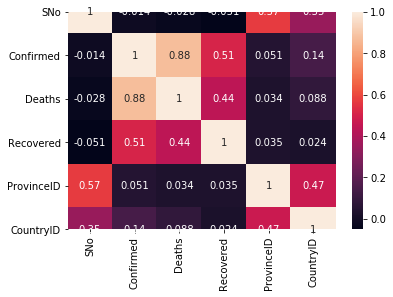

In [69]:
corr= df_update.corr()
sns.heatmap(corr,annot=True)

**There is no strong correlation between any of the variables except for Confirmed, Deaths and Recovered variables**

#  Printing the unique Countries and their count

**A total of 222 countries have been impacted uptill now.**

In [14]:
print(df['Country/Region'].unique())
print("\nNumber of countries impacted by COVID-19:",len(df['Country/Region'].unique()))

['China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal' 'Argentina' 'Chile' 'Jordan' 'Ukraine' 'Saint Barthelemy'
 'Hungary' 'Faroe Islands' 'Gibraltar' 'Liechtenstein' 'Poland' 'Tunisia'
 'Pales

# Representation of confirmed cases per country

In [16]:
group_cases=df_update[['Confirmed','Recovered','Deaths','Country/Region']].groupby('Country/Region').sum().sort_values('Confirmed',ascending=False).head()
group_cases=group_cases.reset_index()
group_cases

,Country/Region,Confirmed,Recovered,Deaths
0,US,1347881,232733,80682
1,Spain,227436,137139,26744
2,UK,224332,1015,32141
3,Russia,221344,39801,2009
4,Italy,219814,106587,30739


**From the below stacked barplot we see that highest number of confirmed cases is in US now<br>**

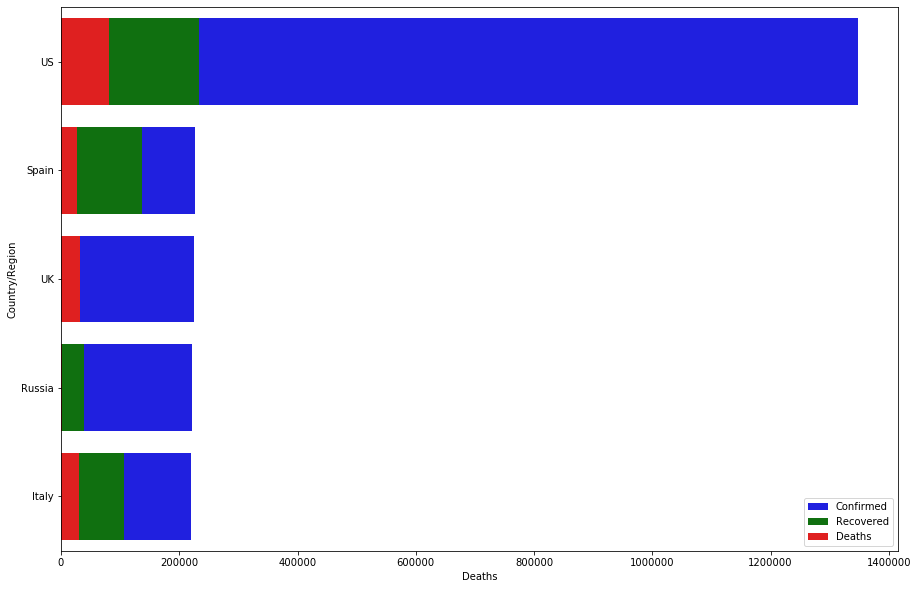

In [17]:
f, ax = plt.subplots(figsize=(15, 10))
bar1=sns.barplot(x="Confirmed",y="Country/Region",data=group_cases,
            label="Confirmed", color="b")


bar2=sns.barplot(x="Recovered", y="Country/Region", data=group_cases,
            label="Recovered", color="g")


bar3=sns.barplot(x="Deaths", y="Country/Region", data=group_cases,
            label="Deaths", color="r")

ax.legend(loc=4, ncol = 1)
plt.show()

**The ratio of recovered and death cases are shown below for the top 5 countries that have reported max deaths. UK has seen more deaths than recoveries while US leads in the number of deaths due to COVID19**

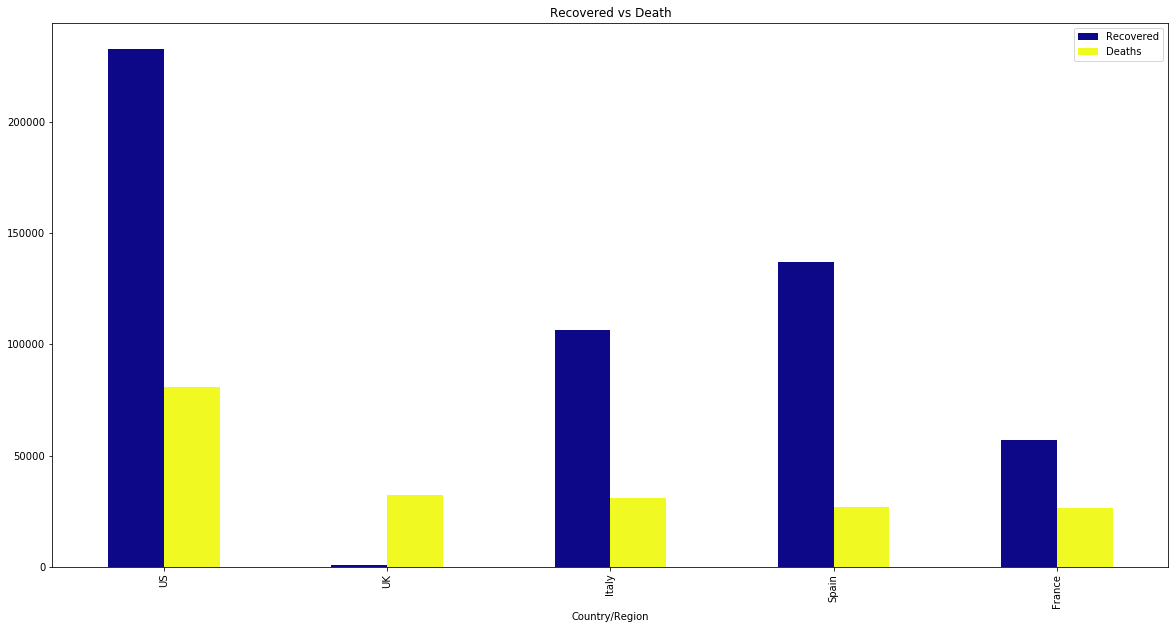

In [20]:
group_cases=df_update[['Recovered','Deaths','Country/Region']].groupby('Country/Region').sum().sort_values('Deaths',ascending=False).head()
group_cases.plot(kind='bar',width=0.5,colormap='plasma',figsize=(20,10))
plt.title("Recovered vs Death")
plt.show()


# India

**Observing the cases in India. Confirmed cases are increasing in India each day. There is a need to get a flatter curve for confirmed cases which currently is in upswing with a steep increase since past few days.**

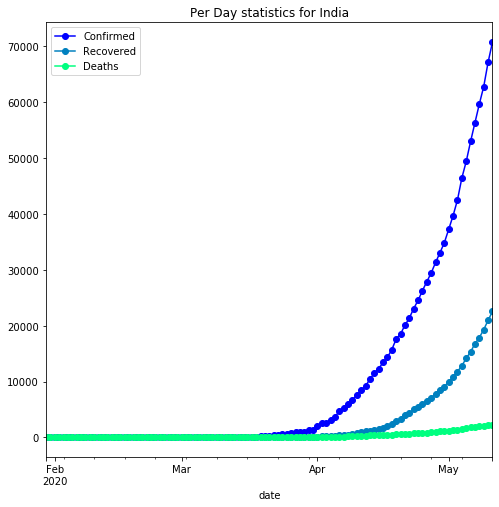

In [70]:
india_cases_complete=df.loc[df['Country/Region']=='India']
india_cases_complete['date'] = india_cases_complete['ObservationDate'].dt.date
india_cases_complete['date']=pd.to_datetime(india_cases_complete['date'])
india_cases_complete = india_cases_complete[india_cases_complete['date'] > pd.Timestamp(date(2020,1,21))]
num_plot = india_cases_complete.groupby('date')["Confirmed", "Recovered", "Deaths"].sum()
num_plot.plot(figsize=(8,8),colormap='winter',title='Per Day statistics for India',marker='o')
num_plot_india=num_plot.reset_index()

In [22]:
num_plot_india['Confirmed Case Increase']=0
num_plot_india['Death Case Increase']=0
num_plot_india['Confirmed Case Increase'][0]=0
num_plot_india['Death Case Increase'][0]=0
for i in range(1,num_plot_india.shape[0]):
    num_plot_india['Confirmed Case Increase'][i]=-(num_plot_india.iloc[i-1][1]-num_plot_india.iloc[i][1])
    num_plot_india['Death Case Increase'][i]=-(num_plot_india.iloc[i-1][3]-num_plot_india.iloc[i][3])
num_plot_india.tail()

,date,Confirmed,Recovered,Deaths,Confirmed Case Increase,Death Case Increase
98,2020-05-07,56351,16776,1889,3364,104
99,2020-05-08,59695,17887,1985,3344,96
100,2020-05-09,62808,19301,2101,3113,116
101,2020-05-10,67161,20969,2212,4353,111
102,2020-05-11,70768,22549,2294,3607,82


**10th May has recorded highest number of COVID19 confirmed cases in India in a day (4353).**

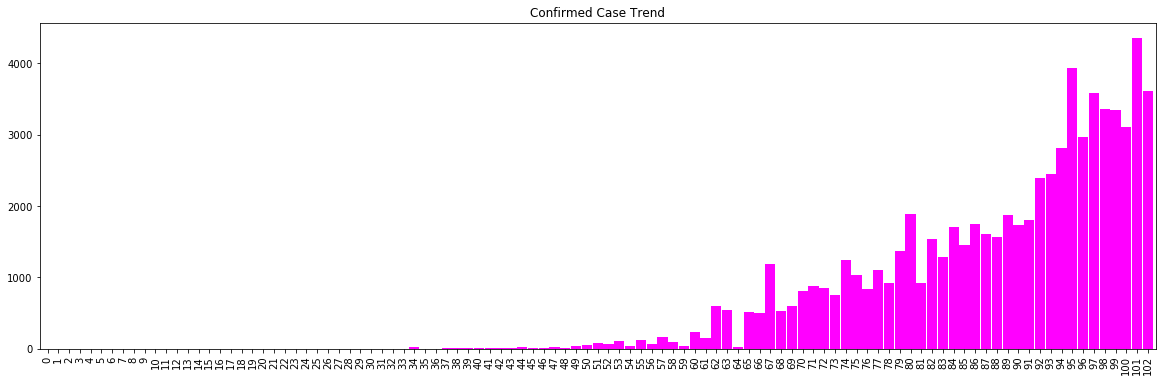

In [27]:
num_plot_india['Confirmed Case Increase'].plot(kind='bar',width=0.95,colormap='spring',figsize=(20,6),title='Confirmed Case Trend')
plt.show()

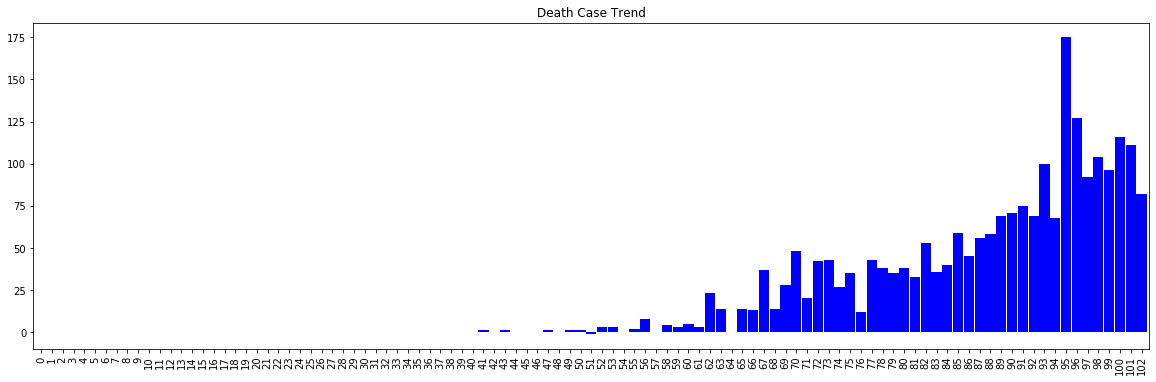

In [28]:
num_plot_india['Death Case Increase'].plot(kind='bar',width=0.95,colormap='winter',figsize=(20,6),title='Death Case Trend')
plt.show()

**Adding other datasources for further analysis of India on State-level**

In [71]:
#Removal of 'Unassigned' State/UnionTerritory
india_covid_19.rename(columns={'State/UnionTerritory': 'State', 'Cured': 'Recovered'}, inplace=True)
unassigned=india_covid_19[india_covid_19['State']=='Unassigned'].index
india_covid_19.drop(unassigned,axis=0,inplace=True)
unassigned1=india_covid_19[india_covid_19['State']=='Nagaland#'].index
india_covid_19.drop(unassigned1,axis=0,inplace=True)
unassigned2=india_covid_19[india_covid_19['State']=='Jharkhand#'].index
india_covid_19.drop(unassigned2,axis=0,inplace=True)
unassigned3=india_covid_19[india_covid_19['State']=='Madhya Pradesh#'].index
india_covid_19.drop(unassigned3,axis=0,inplace=True)

**Statewise Confirmed Cases in India for COVID-2019**

In [72]:

statewise_cases = pd.DataFrame(india_covid_19.groupby(['State'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index())
statewise_cases["Country"] = "India" 
fig = px.treemap(statewise_cases, path=['Country','State'], values='Confirmed',color='Confirmed', hover_data=['State'])
fig.show()

**Gender-wise distribution of the COVID-2019 cases**<br>
The figure shows the cases are more than double in Males than Females

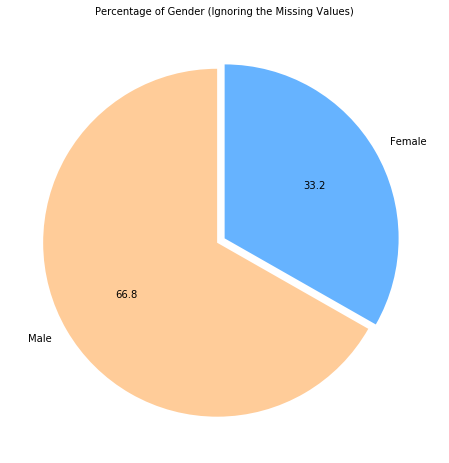

In [38]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])
explode = (0.05, 0)
colors = ['#ffcc99','#66b3ff']
plt.figure(figsize= (8,8))
plt.pie(sizes, explode=explode, labels=labels,colors=colors, autopct='%1.1f',startangle=90)
plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 10)
plt.show ()

**Age-wise distribution of the COVID-2019 cases**<br>
The cases are more common in elderly population as seen in the graph below

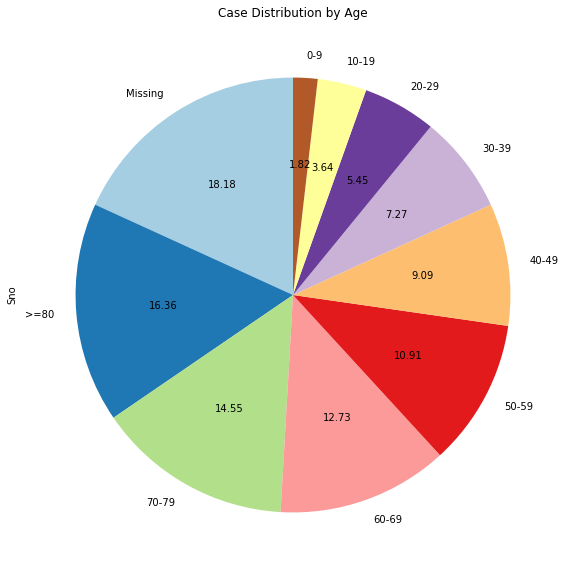

In [39]:
fig = plt.figure(figsize=(10,10))
age_dist_india = age_group.groupby('AgeGroup')['Sno'].sum().sort_values(ascending=False)
def absolute_value(val):
    a  = val
    return (np.round(a,2))
age_dist_india.plot(kind="pie",title='Case Distribution by Age',autopct=absolute_value,colormap='Paired',startangle=90)

plt.show ()

**Statewise Recovery and Death Rate in India**<br>
1)Maharashtra has the highest number of Confirmed cases in India<br>
2) Kerala has highest recovery rate among the top 20 hotspot states in India <br>
3)We have 5 Green states (COVID-19-free) now in India <br>
4)West Bengal has the highest death rate.

In [40]:
india_covid_19['Deaths']=india_covid_19['Deaths'].astype('int')

In [41]:
state_details = pd.pivot_table(india_covid_19, values=['Confirmed','Deaths','Recovered'], index='State', aggfunc='max')
state_details['Recovery Rate'] = round(state_details['Recovered'] / state_details['Confirmed'],2)
state_details['Death Rate'] = round(state_details['Deaths'] /state_details['Confirmed'], 2)
state_details = state_details.sort_values(by='Confirmed', ascending= False)
state_details.style.background_gradient(cmap='Purples')

,Confirmed,Deaths,Recovered,Recovery Rate,Death Rate
State,,,,,
Maharashtra,23401,868,4786,0.200000,0.040000
Gujarat,8541,513,2780,0.330000,0.060000
Tamil Nadu,8002,53,2051,0.260000,0.010000
Delhi,7233,73,2129,0.290000,0.010000
Rajasthan,3988,113,2264,0.570000,0.030000
Madhya Pradesh,3785,221,1747,0.460000,0.060000
Uttar Pradesh,3573,80,1758,0.490000,0.020000
West Bengal,2063,190,499,0.240000,0.090000
Andhra Pradesh,2018,45,975,0.480000,0.020000


**Statewise Testing done so far in India till 1st May**<br>
Maharashtra has done maximum number of tests with 8% of tested cases being positive<br>
Delhi and Gujarat have tested less number of people but still have the highest number of those tested being positive (7%)

In [61]:
import plotly.express as px

In [73]:
testing=state_testing.groupby('State')['Total Tested'].max().sort_values(ascending=False).reset_index()
fig = px.bar(testing, 
             x="Total Tested",
             y="State", 
             orientation='h',
             height=800,
             title='Statewise Testing',
            color='State')
fig.show()

In [43]:
state_test_details = pd.pivot_table(state_testing, values=['Total Tested','Positive','Negative'], index='State', aggfunc='max')
state_test_details['Positive Test Rate'] = round(state_test_details['Positive'] / state_test_details['Total Tested'],2)
state_test_details['Negative Test Rate'] = round(state_test_details['Negative'] /state_test_details['Total Tested'], 2)
state_test_details = state_test_details.sort_values(by='Total Tested', ascending= False)
state_test_details.style.background_gradient(cmap='Blues')

,Negative,Positive,Total Tested,Positive Test Rate,Negative Test Rate
State,,,,,
Maharashtra,140587.000000,11506.000000,151085.000000,0.080000,0.930000
Tamil Nadu,135698.000000,2757.000000,139490.000000,0.020000,0.970000
Rajasthan,104705.000000,2720.000000,113934.000000,0.020000,0.920000
Andhra Pradesh,106878.000000,1525.000000,108403.000000,0.010000,0.990000
Uttar Pradesh,82356.000000,2487.000000,85729.000000,0.030000,0.960000
Karnataka,66475.000000,601.000000,69730.000000,0.010000,0.950000
Gujarat,64053.000000,4721.000000,68774.000000,0.070000,0.930000
Delhi,39920.000000,3439.000000,47225.000000,0.070000,0.850000
Madhya Pradesh,41460.000000,2788.000000,46578.000000,0.060000,0.890000


**Laboratories available for testing in Each of the states**

In [63]:
values = list(ICMR_labs['state'].value_counts())
states = list(ICMR_labs['state'].value_counts().index)
labs = pd.DataFrame(list(zip(values, states)), 
               columns =['values', 'states'])
fig = px.bar(labs, 
             x="values",
             y="states", 
             orientation='h',
             height=1000,
             title='Statewise Labs',
            color='states')
fig.show()

# Predictions for India

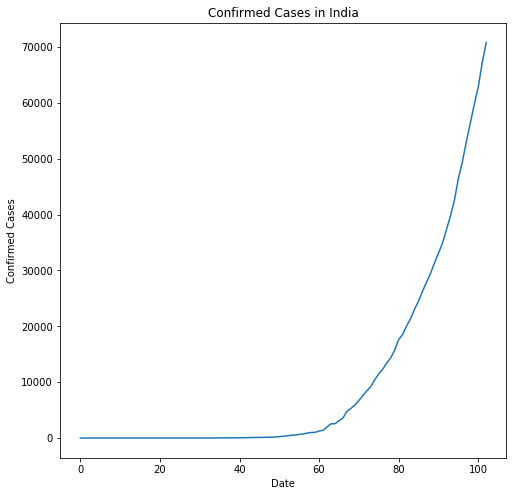

In [46]:
#Current number of confirmed cases
ax = num_plot_india['Confirmed'].plot(title="Confirmed Cases in India",figsize=(8,8));
ax.set(xlabel="Date", ylabel="Confirmed Cases");

**Making Predictions for India based on the current scenario **

**Using Prophet**

In [47]:
train = num_plot_india.iloc[:-3,:2]
test = num_plot_india.iloc[-3:,:2]

In [48]:
train.rename(columns={"date":"ds","Confirmed":"y"},inplace=True)
test.rename(columns={"date":"ds","Confirmed":"y"},inplace=True)
test = test.set_index("ds")
test = test['y']

In [52]:
conda install -c conda-forge fbprophet

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.7.0                |             py_0         1.3 MB  conda-forge
    convertdate-2.2.1          |     pyh9f0ad1d_0          33 KB  conda-forge
    curl-7.69.1                |       h33f0ec9_0         137 KB  conda-forge
    cython-0.29.17             |   py36h831f99a_0         2.2 MB  conda-forge
    ephem-3.7.7.1              |   py36h516909a_0         722 KB  conda-forge
    fbprophet-0.6              |   py36he1b5a44_0         642 KB  conda-forge
    hdf4-4.2.13                |    hf30be14_1003         964 KB  conda-forge
    holidays-0.10.1            |             py_0          56 KB  conda-forge
    libnetcdf-4.6.1            |       h10edf3e_2         833 KB
    lunarcalendar

In [53]:
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
model = Prophet(changepoint_prior_scale=0.4, changepoints=['2020-04-03','2020-04-30','2020-05-05','2020-05-06'])
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**We can see that by 17th May (End of Lockdown 3) more than 91.4k confirmed cases are predicted as per this model with upper limit of around 93.2k. As more data comes in these values will keep changing**

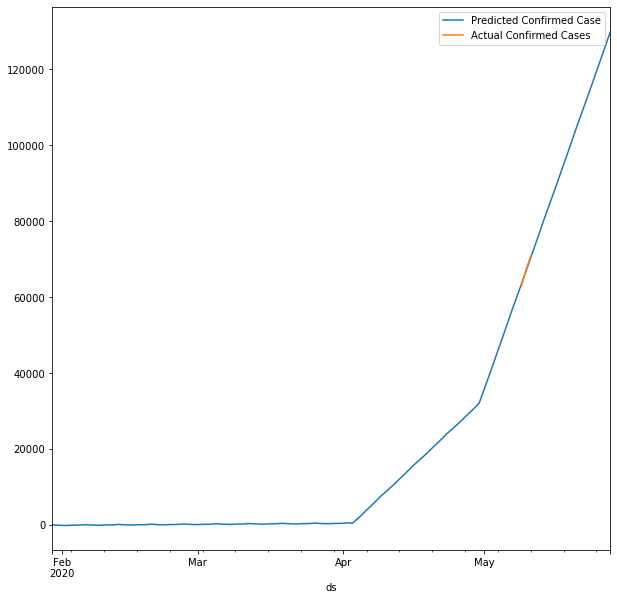

In [54]:
future_dates = model.make_future_dataframe(periods=20)
forecast =  model.predict(future_dates)
ax = forecast.plot(x='ds',y='yhat',label='Predicted Confirmed Case',legend=True,figsize=(10,10))
test.plot(y='y',label='Actual Confirmed Cases',legend=True,ax=ax)

**Accuracy Metrics for Prophet**

In [55]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='60 days', period='20 days', horizon = '3 days')
df_cv.head()
df_p = performance_metrics(df_cv)
df_p.head()


INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-04-15 00:00:00 and 2020-05-05 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,21449.943410,146.457992,127.809290,0.003977,0.003977,1.0
1,2 days,118651.945610,344.458917,263.848391,0.005783,0.005783,1.0
2,3 days,313255.206503,559.692064,558.283048,0.021501,0.021501,1.0


In [56]:
forecast.tail(20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
100,2020-05-09,63402.628774,62211.971996,64604.173009,63402.628774,63402.628774,-41.777909,-41.777909,-41.777909,-41.777909,-41.777909,-41.777909,0.0,0.0,0.0,63360.850865
101,2020-05-10,66900.755531,65554.045553,68021.545441,66900.755531,66900.755531,-81.138355,-81.138355,-81.138355,-81.138355,-81.138355,-81.138355,0.0,0.0,0.0,66819.617176
102,2020-05-11,70398.882287,69140.553321,71644.788615,70398.882287,70398.882287,-12.854920,-12.854920,-12.854920,-12.854920,-12.854920,-12.854920,0.0,0.0,0.0,70386.027367
103,2020-05-12,73897.009044,72436.677633,75296.318109,73897.009044,73897.009044,-18.500760,-18.500760,-18.500760,-18.500760,-18.500760,-18.500760,0.0,0.0,0.0,73878.508284
104,2020-05-13,77395.135800,76015.949324,78805.121667,77395.135800,77395.135800,22.783379,22.783379,22.783379,22.783379,22.783379,22.783379,0.0,0.0,0.0,77417.919179
105,2020-05-14,80893.262556,79586.958027,82331.536253,80739.877615,80954.265977,110.797114,110.797114,110.797114,110.797114,110.797114,110.797114,0.0,0.0,0.0,81004.059670
106,2020-05-15,84391.389313,82814.949268,85906.917504,83978.762322,84688.261670,20.691451,20.691451,20.691451,20.691451,20.691451,20.691451,0.0,0.0,0.0,84412.080764
107,2020-05-16,87889.516069,86182.209699,89509.387654,87040.452441,88704.455937,-41.777909,-41.777909,-41.777909,-41.777909,-41.777909,-41.777909,0.0,0.0,0.0,87847.738160
108,2020-05-17,91387.642826,89428.482937,93143.384613,90196.430950,92893.032270,-81.138355,-81.138355,-81.138355,-81.138355,-81.138355,-81.138355,0.0,0.0,0.0,91306.504470
109,2020-05-18,94885.769582,92824.082265,97366.856059,93241.288266,97007.534663,-12.854920,-12.854920,-12.854920,-12.854920,-12.854920,-12.854920,0.0,0.0,0.0,94872.914662


**Prediction considering till when entire population of India will be impacted**<br>
If we consider logistic growth, between mid July to November the daily number of confirmed cases will be rising and by mid November we will be at the peak with daily increase being constant thereafter.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


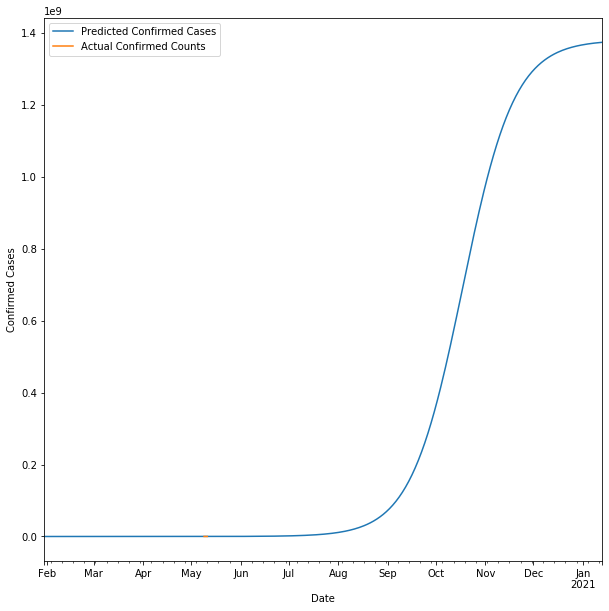

In [57]:
from fbprophet import Prophet
model_india = Prophet(growth="logistic",changepoint_prior_scale=0.4,changepoints=['2020-04-03','2020-04-30','2020-05-05','2020-05-06'])
pop = 1380004385 #from worldometers
train['cap'] = pop
model_india.fit(train)
# Future Prediction
future_dates = model_india.make_future_dataframe(periods=250)
future_dates['cap'] = pop
forecast =  model_india.predict(future_dates)
# Plotting
ax = forecast.plot(x='ds',y='yhat',label='Predicted Confirmed Cases',legend=True,figsize=(10,10))
test.plot(y='y',label='Actual Confirmed Counts',legend=True,ax=ax)
ax.set(xlabel="Date", ylabel="Confirmed Cases");